In [166]:
@hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='73802bf4-4b54-454b-b2a7-80636124afd8', project_access_token='p-545c1bb477dc7b601c294c0a660e14a51fe423ee')
pc = project.project_context


# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans 

from scipy.stats import itemfreq, chisquare


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# # load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [3]:
# # save data locally
# azdias.to_csv('Udacity_AZDIAS.csv', sep=';', index=False)
# customers.to_csv('Udacity_CUSTOMERS.csv', sep=';', index=False)


In [4]:
#load locally
#azdias = pd.read_csv('Udacity_AZDIAS.csv', sep=';')

from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_a858d8f03f374020bfd0da2bb1a90a17 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='XXXX',
    ibm_auth_endpoint="xxx",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='udacity-donotdelete-pr-cg1e1uk11mv7lb',Key='Udacity_AZDIAS.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

azdias = pd.read_csv(body, sep=';')
azdias.head()


/opt/conda/envs/Python-3.6-CUDA/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
azdias_copy = azdias.copy()

In [6]:
azdias.shape

(891221, 366)

In [7]:
azdias.columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=366)

In [8]:
#check mixed type columns

azdias[azdias.columns[azdias.dtypes == 'object'].values]

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W
6,4A,4,22,D19_UNBEKANNT,1992-02-12 00:00:00,W
7,2D,2,14,D19_UNBEKANNT,1992-02-10 00:00:00,W
8,1A,1,13,NaN,1992-02-10 00:00:00,W
9,1E,1,15,D19_KOSMETIK,1992-02-10 00:00:00,W


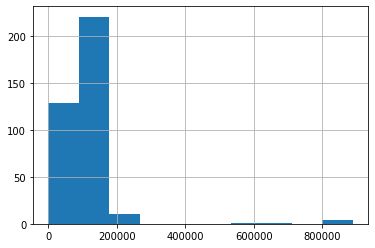

In [9]:
#plot distribution of missing values
azdias_copy.isna().sum().hist()

In [10]:
#how many columns have missing values
len(azdias_copy.columns[azdias_copy.isnull().any()])

273

In [11]:
#sort missing values
azdias_copy.isna().sum().sort_values(ascending=False)

ALTER_KIND4                    890016
ALTER_KIND3                    885051
ALTER_KIND2                    861722
ALTER_KIND1                    810163
EXTSEL992                      654153
KK_KUNDENTYP                   584612
ALTERSKATEGORIE_FEIN           262947
D19_LETZTER_KAUF_BRANCHE       257113
D19_LOTTO                      257113
D19_VERSI_ONLINE_QUOTE_12      257113
D19_BANKEN_ONLINE_QUOTE_12     257113
D19_SOZIALES                   257113
D19_GESAMT_ONLINE_QUOTE_12     257113
D19_KONSUMTYP                  257113
D19_TELKO_ONLINE_QUOTE_12      257113
D19_VERSAND_ONLINE_QUOTE_12    257113
KBA05_MOTOR                    133324
KBA05_MOD8                     133324
KBA05_MOD4                     133324
KBA05_MOD3                     133324
KBA05_MOD2                     133324
KBA05_SEG1                     133324
KBA05_MOD1                     133324
KBA05_MAXVORB                  133324
KBA05_MAXSEG                   133324
KBA05_MAXHERST                 133324
KBA05_MAXBJ 

In [12]:
# Investigate patterns in the amount of missing data in each column.

nans = (azdias_copy.isnull().mean()).sort_values(ascending=False)
nans[:30]

ALTER_KIND4                    0.998648
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
ALTERSKATEGORIE_FEIN           0.295041
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_LOTTO                      0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_SOZIALES                   0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_KONSUMTYP                  0.288495
D19_TELKO_ONLINE_QUOTE_12      0.288495
D19_VERSAND_ONLINE_QUOTE_12    0.288495
KBA05_MOTOR                    0.149597
KBA05_MOD8                     0.149597
KBA05_MOD4                     0.149597
KBA05_MOD3                     0.149597
KBA05_MOD2                     0.149597
KBA05_SEG1                     0.149597
KBA05_MOD1                     0.149597
KBA05_MAXVORB                  0.149597
KBA05_MAXSEG                   0.149597


In [13]:
#Function to plot proportion of missing values
def plot_graphs(df, x_label, y_label, bin_size):
    f, (ax_box, ax_hist) = plt.subplots(2,
                                        sharex=True,
                                        gridspec_kw={
                                            "height_ratios": (.15, .85)},
                                        figsize=(14, 6))

    sns.boxplot(df, ax=ax_box)
    bins = np.arange(0, df.max() + bin_size, bin_size)
    df.hist(grid=False, bins=bins)
    ax_box.set(yticks=[])
    ax_hist.set_ylabel(y_label)
    ax_hist.set_xlabel(x_label)
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)

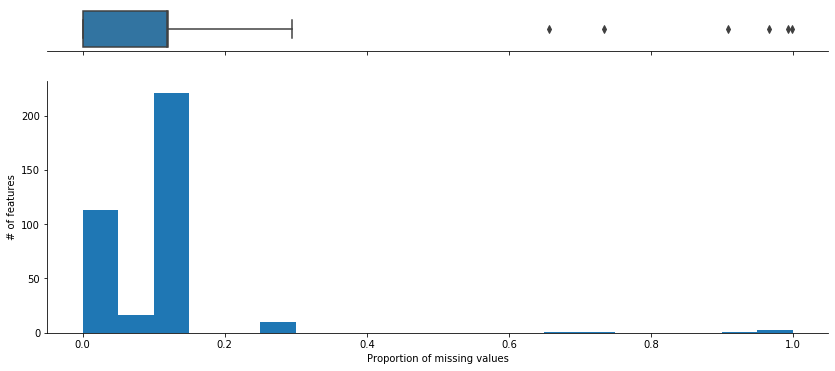

In [14]:
plot_graphs(nans, x_label='Proportion of missing values', y_label='# of features', bin_size=0.05);

In [15]:
# Remove the outlier and unecessary columns and  from the dataset
drop_cols = ['ALTER_KIND4','ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'EXTSEL992','KK_KUNDENTYP', 'LNR','EINGEFUEGT_AM','GEBURTSJAHR']                 


In [16]:
azdias_copy = azdias_copy.drop(drop_cols, axis=1)

**Assess missing row data**

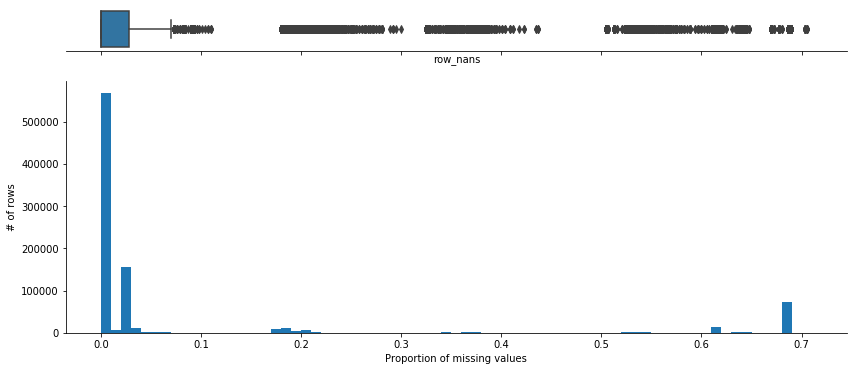

In [17]:
# How much data is missing in each row of the dataset?
azdias_copy['row_nans'] = azdias_copy.isna().mean(axis=1) 
plot_graphs(azdias_copy['row_nans'], x_label='Proportion of missing values', y_label='# of rows', bin_size=0.01)

In [18]:
# Divide the data into two subsets based on the number of missing
# values in each row.
boundary = 0.1
low_nan = azdias_copy.loc[azdias_copy['row_nans'] < boundary, :]
high_nan = azdias_copy.loc[azdias_copy['row_nans'] > boundary, :]


In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
val_dist = list(set(low_nan.dropna(axis=1).columns).intersection(high_nan.dropna(axis=1).columns))
val_dist

['NATIONALITAET_KZ',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_SONSTIGE',
 'SEMIO_RAT',
 'D19_GESAMT_ANZ_24',
 'SEMIO_DOM',
 'D19_BANKEN_LOKAL',
 'D19_VERSAND_DATUM',
 'ANREDE_KZ',
 'D19_KOSMETIK',
 'FINANZ_VORSORGER',
 'D19_GARTEN',
 'D19_VERSI_ANZ_12',
 'SEMIO_MAT',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VOLLSORTIMENT',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_REST',
 'SEMIO_TRADV',
 'ZABEOTYP',
 'D19_ENERGIE',
 'D19_TELKO_ANZ_24',
 'HEALTH_TYP',
 'FINANZ_ANLEGER',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BILDUNG',
 'AGER_TYP',
 'D19_RATGEBER',
 'SEMIO_VERT',
 'D19_BIO_OEKO',
 'D19_VERSI_DATUM',
 'FINANZTYP',
 'SEMIO_ERL',
 'row_nans',
 'D19_LEBENSMITTEL',
 'FINANZ_UNAUFFAELLIGER',
 'D19_DIGIT_SERV',
 'ALTERSKATEGORIE_GROB',
 'SEMIO_KRIT',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_TELKO_DATUM',
 'VERS_TYP',
 'D19_VERSAND_ANZ_24',
 'D19_BANKEN_ANZ_24',
 'D19_WEIN_FEINKOST',
 'D19_REISEN',
 'GREEN_AVANTGARDE',
 'D19_SCHUHE',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'SEMIO_LUST',
 

In [20]:
# Drop the 'row_nans' column
val_dist.remove('row_nans')

In [21]:
azdias_copy = low_nan

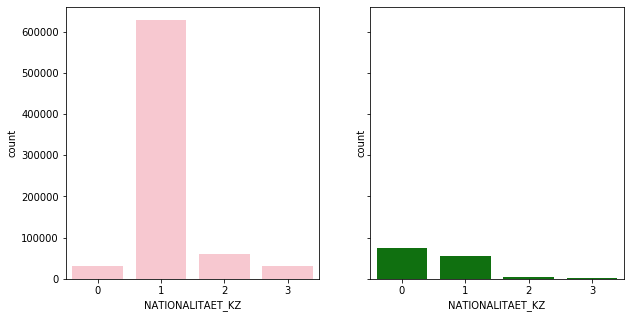

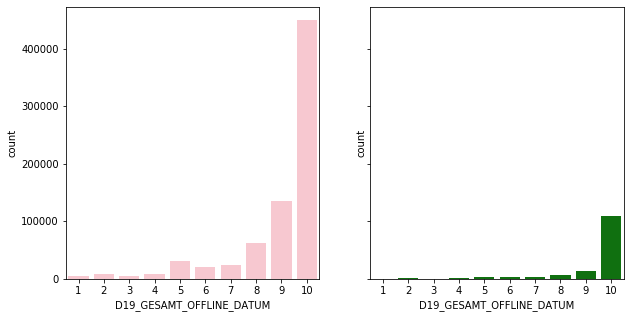

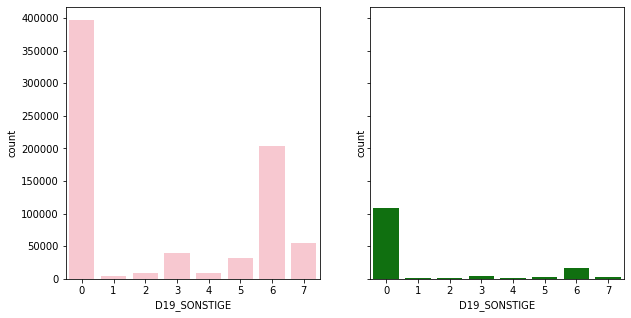

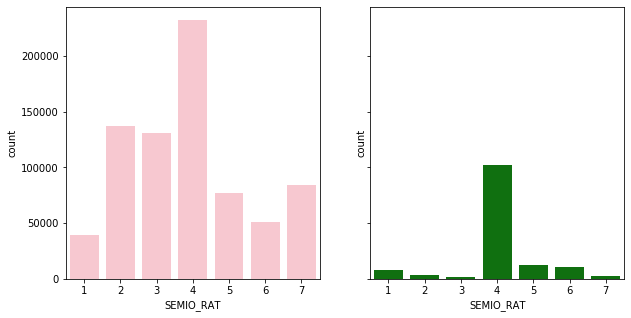

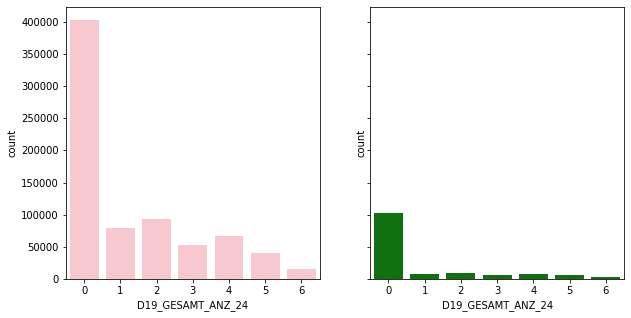

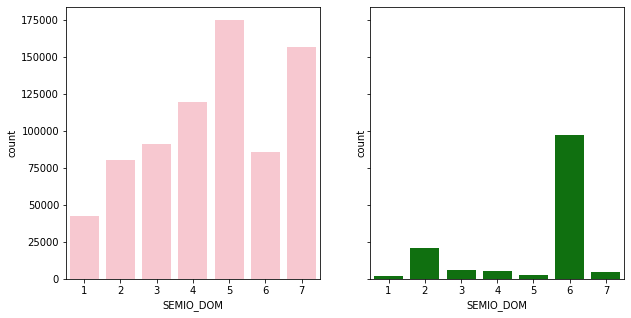

In [23]:
#value distribution plots for five columns with few missing vals
for col in val_dist[:6]:
    fig, axes = plt.subplots(1,2, figsize= (10,5), sharey=True)
    sns.countplot(low_nan[col], ax=axes[0], color='pink')
    sns.countplot(high_nan[col], ax=axes[1], color='g')

In [24]:
# Drop the row nan percentage row from azdias_copy
df = azdias_copy[azdias_copy.columns[:-1]]
df.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,3,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [25]:
df.shape

(751324, 357)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [26]:

body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='udacity-donotdelete-pr-cg1e1uk11mv7lb',Key='missing_vals.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

nan_df = pd.read_csv(body)
nan_df.head()


,column,missing_unknown
0,AGER_TYP,['-1']
1,ALTERSKATEGORIE_GROB,"['-1','0']"
2,ANREDE_KZ,"['-1','0']"
3,BALLRAUM,['-1']
4,CAMEO_DEUG_2015,"['-1','X']"


In [27]:

#the lists became strings -> lexing and parsing
nan_df['missing_unknown'] = nan_df['missing_unknown'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').split(','))
nan_df.head()

,column,missing_unknown
0,AGER_TYP,[-1]
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ANREDE_KZ,"[-1, 0]"
3,BALLRAUM,[-1]
4,CAMEO_DEUG_2015,"[-1, X]"


In [28]:
import sys
!{sys.executable} -m pip install progressbar

In [29]:
import progressbar

In [30]:
def convert_to_nans(df):
    #This function will go throu all columns in the loaded file and will change nan representing values to np.nan 
    bar = progressbar.ProgressBar(maxval=len(nan_df['column'])+1, widgets=[progressbar.Bar('->', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    counter=0
    for col in nan_df['column']:
        for i in nan_df.query('column == @col')['missing_unknown'].values[0]:
            if i not in ['XX','X','']:
                i=np.float64(i)
            if i == '':
                i = np.nan
            try:
                df.loc[df[col] == i, col] = np.nan
            except:
                print('error in {}'.format(col))
        counter+=1
        bar.update(counter)
    bar.finish()
    return df
df = convert_to_nans(df)



/opt/conda/envs/Python-3.6-CUDA/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
[->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->] 100%


In [31]:
df.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,NaN,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,NaN,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,2.0,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,NaN,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
5,3.0,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0


In [32]:
#check which columns are categorical
df_cat = df[df.columns[df.dtypes == 'object'].values]

In [33]:
df_cat.head()


,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,OST_WEST_KZ
1,8A,8,51,NaN,W
2,4C,4,24,D19_UNBEKANNT,W
3,2A,2,12,D19_UNBEKANNT,W
4,6B,6,43,D19_SCHUHE,W
5,8C,8,54,D19_ENERGIE,W


### Re-Encode Categorical Features
OST_WEST_KZ: Building location via former East / West Germany (GDR / FRG) (O: East (GDR), W: West (FRG)) this is a binary categorical feature so instead of putting O and W we can change it to 0 and 1 to make it easier for the model to work with.

CAMEO_DEUG_2015 German CAMEO: Wealth / Life Stage Typology, rough scale (1: upper class, 9: urban working class) has numerical values but is stored as an object. This multilevel categorical feature and can be transformed to int64.

CAMEO_DEU_2015 ( Wealth / Life Stage Typology) )is more confusing since it has 44 different value types. Wealth / Life Stage Typology. This can be dropped since it has too much information to re-encode for our model.

In [34]:
# Reencode OST_WEST_KZ to numeric 0/1
df = df.copy()
df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O': 0, 
                                               'W': 1})

In [35]:

#changes numbers that are saved as objects
df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(lambda x: int(x) if x==x else x )
df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x) if x==x else x )

### Mixed_type feautures


In [36]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
#(Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west))
df.PRAEGENDE_JUGENDJAHRE.sample(20)

555362    15.0
304061    11.0
64661      3.0
150490     8.0
568846     3.0
662795     8.0
472283    13.0
103876     8.0
83835      8.0
774749     5.0
83493     14.0
832505    10.0
600933    13.0
595426     8.0
181606    14.0
489937    14.0
7455      15.0
241935    14.0
694314     5.0
837851     5.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [37]:
df.PRAEGENDE_JUGENDJAHRE.nunique()

15

About this feature:
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

Seems like for every decade there are two movements: Mainstream and Avantgarde. We can create two new variables that separate this by decade and by movement.

DECADE:

Person’s decade of youth.

1: 40s
2: 50s
3: 60s
4: 70s
5: 80s
6: 90s
    
MOVEMENT:

Person’s movement

1: Mainstream
2: Avantgarde

In [38]:
decade_dict = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
               8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
               14: 6, 15: 6
              }
movement_dict = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2
                }


# Ref: https://stackoverflow.com/questions/20250771/remap-values-in-pandas-column-with-a-dict
df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)

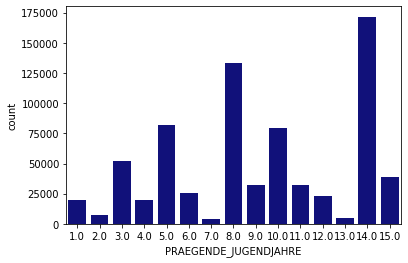

In [39]:
#Let's look at the distribution of this feature
sns.countplot(data= df, x='PRAEGENDE_JUGENDJAHRE',color='darkblue');

## Investigate "CAMEO_INTL_2015" and engineer two new variables.

CAMEO_INTL_2015: Wealth / Life Stage Typology, mapped to international code

-1: unknown
11: Wealthy Households - Pre-Family Couples & Singles
12: Wealthy Households - Young Couples With Children
13: Wealthy Households - Families With School Age Children
14: Wealthy Households - Older Families & Mature Couples
15: Wealthy Households - Elders In Retirement
21: Prosperous Households - Pre-Family Couples & Singles
22: Prosperous Households - Young Couples With Children
23: Prosperous Households - Families With School Age Children
24: Prosperous Households - Older Families & Mature Couples
25: Prosperous Households - Elders In Retirement
31: Comfortable Households - Pre-Family Couples & Singles
32: Comfortable Households - Young Couples With Children
33: Comfortable Households - Families With School Age Children
34: Comfortable Households - Older Families & Mature Couples
35: Comfortable Households - Elders In Retirement
41: Less Affluent Households - Pre-Family Couples & Singles
42: Less Affluent Households - Young Couples With Children
43: Less Affluent Households - Families With School Age Children
44: Less Affluent Households - Older Families & Mature Couples
45: Less Affluent Households - Elders In Retirement
51: Poorer Households - Pre-Family Couples & Singles
52: Poorer Households - Young Couples With Children
53: Poorer Households - Families With School Age Children
54: Poorer Households - Older Families & Mature Couples
55: Poorer Households - Elders In Retirement
XX: unknow

In [40]:
df.CAMEO_INTL_2015.head(10)

1     51.0
2     24.0
3     12.0
4     43.0
5     54.0
6     22.0
7     14.0
8     13.0
9     15.0
10    51.0
Name: CAMEO_INTL_2015, dtype: float64

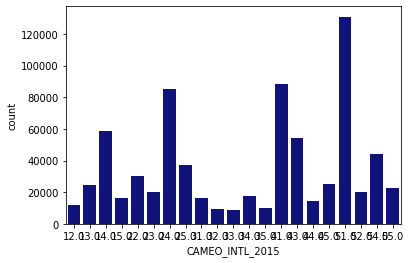

In [41]:
#Let's look at the distribution of this feature
sns.countplot(data= df, x='CAMEO_INTL_2015',color='darkblue');

New Variables:

WEALTH:

Household's wealth

1: Wealthy Households
2: Prosperous Households
3: Comfortable Households
4: Less Affluent Households
5: Poorer Households
    
LIFE_STAGE:

Person's Life Stage

1: Pre-Family Couples & Singles
2: Young Couples With Children
3: Families With School Age Children
4: Older Families & Mature Couples
5: Elders In Retirement

In [42]:
def break_digits(x, digit):
    ''' Breaks up  two-digit codes by
    'tens'-place and 'ones'-place digits
    into two new ordinal variables.
    Leaves NaNs unchanged'''

    if not pd.isna(x):
        if digit == 'first':
            return int(str(x)[0])
        elif digit == 'second':
            return int(str(x)[1])
    return x

In [43]:
df['WEALTH'] = df['CAMEO_INTL_2015'].apply(break_digits, digit='first')
df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(break_digits, digit='second')

Based on the excel sheet:

In [44]:
mixed_feats =  ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']

In [45]:
# Drop mixed features
df = df.drop(mixed_feats, axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features
For the PRAEGENDE_JUGENDJAHRE:
Seems like for every decade there are two movements: Mainstream and Avantgarde. We can create two new variables that separate this by decade and by movement. This is how they were coded:

DECADE:

Person’s decade of youth.

1: 40s 2: 50s 3: 60s 4: 70s 5: 80s 6: 90s

MOVEMENT:

Person’s movement

1: Mainstream 2: Avantgarde

For the CAMEO_INTL_2015, it was split between a person's wealth and life stage. In order to do this I had to use the original first digit of the value to represent the wealth and the second digit represents that person's life stage.

The other mixed features can be dropped since they would overcomplicate the model.

#### Feature Selection

In [46]:
df.columns

Index(['AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL',
       ...
       'VK_ZG11', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB', 'DECADE', 'MOVEMENT', 'WEALTH', 'LIFE_STAGE'],
      dtype='object', length=355)

In [47]:
#float columns given by excel file
float_columns = ['ANZ_HAUSHALTE_AKTIV',
'ANZ_HH_TITEL',
'ANZ_PERSONEN',
'ANZ_TITEL',
'KBA13_ANZAHL_PKW',
'MIN_GEBAEUDEJAHR']

In [48]:
object_columns = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE']

In [49]:

# int columns are the categorical columns
int_columns = np.setdiff1d(df.columns,float_columns+object_columns)

In [50]:
def fill_columns(df, columns, filling):
    # filling the diferent columns with the apropriate values
    bar = progressbar.ProgressBar(maxval=len(columns)+1, widgets=[progressbar.Bar('->', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    counter = 0
    for col in columns:
        if filling == 'mean':
            df[col]=df[col].fillna(df[col].mean())
        if filling == 'median':
            df[col]=df[col].fillna(df[col].median())
        counter+=1
        bar.update(counter)
    bar.finish()
    return df

In [51]:

df = fill_columns(df, float_columns, 'mean')
df = fill_columns(df, int_columns, 'median')

[->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->] 100%
[->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->] 100%


In [52]:
df[df.columns[df.dtypes == 'object'].values].columns

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE'], dtype='object')

In [53]:

#which columns still have missing values?
(df.isnull().sum()/len(df)).sort_values(ascending=False)[:3]

D19_LETZTER_KAUF_BRANCHE    0.227729
CAMEO_DEU_2015              0.004797
KBA05_CCM1                  0.000000
dtype: float64

In [54]:
df.D19_LETZTER_KAUF_BRANCHE.unique()

array([nan, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
       'D19_SONSTIGE', 'D19_BANKEN_GROSS', 'D19_VOLLSORTIMENT',
       'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD',
       'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_LEBENSMITTEL',
       'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST', 'D19_SAMMELARTIKEL',
       'D19_TELKO_MOBILE', 'D19_REISEN', 'D19_BEKLEIDUNG_GEH',
       'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG', 'D19_DIGIT_SERV',
       'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL',
       'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_FREIZEIT',
       'D19_WEIN_FEINKOST', 'D19_GARTEN', 'D19_BILDUNG',
       'D19_BANKEN_LOKAL'], dtype=object)

In [55]:
#fill this columns missing values with the most common value
df['D19_LETZTER_KAUF_BRANCHE'] = df['D19_LETZTER_KAUF_BRANCHE'].fillna('D19_UNBEKANNT')

In [56]:

#drop remaining nans
df = df.dropna(axis=0)

In [57]:
df[df.columns[df.dtypes == 'object'].values].columns

Index(['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE'], dtype='object')

In [58]:
df = pd.get_dummies(df, columns=['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE'])

In [59]:
df.shape

(747720, 432)

In [60]:

# # Check if all colums are of numeric dtype
from pandas.api.types import is_numeric_dtype

#should be equal to the no of cols if all True
assert(sum([is_numeric_dtype(df[col]) for col in df.columns]) == df.shape[1])
print('Tests OK')

Tests OK


In [61]:
df.shape

(747720, 432)

In [62]:
def drop_rows(df):
    '''split the dataset into two parts:
    One with a percntage of NaN per row over the threshhold
    and one below. Return both.'''
    df['row_nans'] = df.isna().mean(axis=1)
    threshhold = 0.1
    df['row_nan_perc'] = df.isnull().mean(axis=1)
    
    df_lowna = df.loc[df['row_nan_perc'] < threshhold, :].\
                                drop(columns='row_nan_perc', axis=1)
    df_highna = df.loc[df['row_nan_perc'] > threshhold, :].\
                                drop(columns='row_nan_perc', axis=1)

    return df_lowna, df_highna

### Create a Cleaning Function

In [63]:
def clean_data(df):
    
    # Remove the outlier and unecessary columns and  from the dataset
    
    df = convert_to_nans(df)
    print('Convert missing value codes into NaN, OK')

    # remove selected columns , ...
    df = drop_columns(df)
    
    print('Remove selected columns, OK')
    
    # select, re-encode, and engineer column values.
    df = reencode_cat_feats(df)
    df = engineer_mixed_feat(df)
    df = fill_columns(df, float_columns, 'mean')
    df = fill_columns(df, int_columns, 'median')
    df = fill_na(df)
    
    print('Re-encode, fill and engineer column value, OK')
    
    # Return the cleaned dataframe
    return df

def convert_to_nans(df):
    #This function will go throu all columns in the loaded file and will change nan representing values to np.nan 
    bar = progressbar.ProgressBar(maxval=len(nan_df['column'])+1, widgets=[progressbar.Bar('->', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    counter=0
    for col in nan_df['column']:
        for i in nan_df.query('column == @col')['missing_unknown'].values[0]:
            if i not in ['XX','X','']:
                i=np.float64(i)
            if i == '':
                i = np.nan
            try:
                df.loc[df[col] == i, col] = np.nan
            except:
                print('error in {}'.format(col))
        counter+=1
        bar.update(counter)
    bar.finish()
    return df


def drop_columns(df):
    ''''''
    return df.drop(columns=drop_cols, axis=1)



def reencode_cat_feats(df):
    ''''''
    # Reencode the binary OST_WEST_KZ to 0/1
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O': 0,
                                                   'W': 1})
    #changes numbers that are saved as objects
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].apply(lambda x: int(x) if x==x else x )
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x) if x==x else x )
    
    return df

def engineer_mixed_feat(df):
    '''Engineer new variables from 
    mixed features. Drop old features'''
    # Engineer two new variables from 'PRAEGENDE_JUGENDJAHRE'
    decade_dict = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
                   8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
                   14: 6, 15: 6
                   }
    movement_dict = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                     2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2
                     }

    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    

    # Engineer two new variables from 'CAMEO_INTL_2015'
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(
        break_digits, digit='first')
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(
        break_digits, digit='second')

    # Drop mixed dtype features
    
    mixed_feats =  ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']
    df = df.drop(mixed_feats, axis=1)
    
    return df

def fill_columns(df, columns, filling):
    #float columns given by excel file
    float_columns = ['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL','ANZ_PERSONEN','ANZ_TITEL', 'KBA13_ANZAHL_PKW','MIN_GEBAEUDEJAHR']
    object_columns = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE']
    # int columns are the categorical columns
    int_columns = np.setdiff1d(df.columns,float_columns+object_columns)
    # filling the diferent columns with the apropriate values
    bar = progressbar.ProgressBar(maxval=len(columns)+1, widgets=[progressbar.Bar('->', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    counter = 0
    for col in columns:
        if filling == 'mean':
            df[col]=df[col].fillna(df[col].mean())
        if filling == 'median':
            df[col]=df[col].fillna(df[col].median())
        counter+=1
        bar.update(counter)
    bar.finish()
  
    return df

def fill_na(df):
  #drop remaining nans
    df['D19_LETZTER_KAUF_BRANCHE'] = df['D19_LETZTER_KAUF_BRANCHE'].fillna('D19_UNBEKANNT')
    df = pd.get_dummies(df, columns=['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE'])
    
    return df


## Feature Transformation



In [64]:

# Percentage of nans per column
(df.isnull().mean(axis=0) * 100).sort_values(ascending=False)[:15]

D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST    0.0
KBA05_MAXVORB                                 0.0
KBA05_KRSKLEIN                                0.0
KBA05_KRSOBER                                 0.0
KBA05_KRSVAN                                  0.0
KBA05_KRSZUL                                  0.0
KBA05_KW1                                     0.0
KBA05_KW2                                     0.0
KBA05_KW3                                     0.0
KBA05_MAXAH                                   0.0
KBA05_MAXBJ                                   0.0
KBA05_MAXHERST                                0.0
KBA05_MAXSEG                                  0.0
KBA05_MOD1                                    0.0
D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT    0.0
dtype: float64

In [65]:
# Percentage of nans per row 
nan_perc = (df.isnull().mean(axis=1) * 100).sort_values(ascending=False)

#How many rows have nans?
nan_perc[nan_perc > 0].shape[0]

0

In [66]:
df.isnull().sum().sum() 

0

In [67]:
# Check to make sure no nans left
print('Total percentage of Nans : ',
      round(df.isnull().sum().sum() / np.product(df.shape) * 100, 2),
      '%')

Total percentage of Nans :  0.0 %


In [68]:
df.shape

(747720, 432)

In [69]:
# Fit the Scaler without NaNs
scaler = StandardScaler()


In [70]:
# Apply feature scaling to the general population demographics data.
# Transform the df with the fitted scaler
X_scale = scaler.fit_transform(df)

###  Apply Feature Scaling

### Discussion: Apply Feature Scaling

Since the total percentage of NaNs in the dataset is 0.67%, we would lose a lot of data by dropping them. Thus it is better to impute them with the mean and then transforming them with the StandardScaler after fitting them. This will keep the distribution and a higher percentage of the data.

In [71]:
X_scale.shape

(747720, 432)

## Clustering

### Apply Clustering to General Population

In [72]:
# Over a number of different cluster counts...
#from Udacity lessons:
def get_kmeans_score(data, center):
    'returns the kmeans scores regarding SSE for points to centers'
    'Input:'
    'data: dataset you want to fit kmeans to'
    'centers- the numbers of centers'
    'output: SSE score for the kmeans model fit to the data'
    
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters= center)
    
    #fit model
    model = kmeans.fit(data)
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(data))
    return score

In [73]:
pca = PCA(n_components=150)
X_pca = pca.fit_transform(X_scale)

In [74]:
#ratio of explained variance
sum(pca.explained_variance_ratio_)

0.7472913221734067

From the cumulative sum of the first 150 components, 74.7% of the variance can be explained. By performing dimensionality reduction PCA() method to the scaled dataset, it is best to keep 150 components since adding more components resulted in my machine crashing.

In [75]:
scores = []
centers = list(range(1, 30, 3))
for center in centers:
    scores.append(get_kmeans_score(X_pca, center))

In [76]:
#Saved the scores to print later in the plot since clustering is time consuming to run each time
print(scores)

[241386336.32349575, 212676037.0620369, 203444736.0337678, 198019719.16069737, 194572602.33957493, 191733088.11850098, 189654588.71138942, 187989566.09285823, 185740931.99323434, 184236396.74484104]


In [77]:
# scores1 = [99828911.92403707, 71223560.78828095, 62240661.975860074, 57081973.025226004, 54112846.97642098, 51783748.65631021, 49930335.96231076, 48419565.94388852, 47216261.91219105, 46183699.5839111]

Text(0.5, 1.0, 'SSE vs. K')

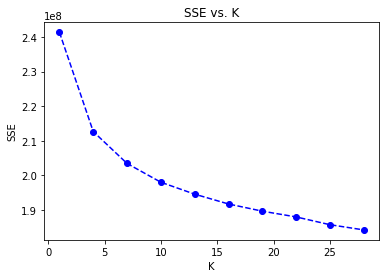

In [78]:
# Investigate the change in within-cluster distance across number of clusters.
# Matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K')

In [79]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters=10)
model_10 = kmeans.fit(X_pca)

In [80]:
kmeans.cluster_centers_.shape

(10, 150)

In [81]:
cluster_predictions = model_10.predict(X_pca)

### Apply Clustering to Customer Data

The elbow in the curve where adding additional clusters would be less effective in reducing the within-cluster distance happens at 10.

I chose ten to not overgeneralize the clusters and since this was the last number before the elbow started lowering after this number. This number can be used to fit the the KMeans algorithm on the transformed demographics data and predict cluster labels. 

In [ ]:
# customers = pd.read_csv('Udacity_CUSTOMERS.csv', sep=';')

In [82]:
#loading the data set
body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='udacity-donotdelete-pr-cg1e1uk11mv7lb',Key='Udacity_CUSTOMERS.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

customers = pd.read_csv(body, sep=';')
customers.head()


/opt/conda/envs/Python-3.6-CUDA/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [83]:
df_cust_lowna, df_cust_highna = drop_rows(customers)

In [84]:
#clean train data
df_cust = clean_data(customers)

[->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->] 100%


Convert missing value codes into NaN, OK
Remove selected columns, OK


[->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->] 100%
[->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->] 100%


Re-encode, fill and engineer column value, OK


In [85]:
df_cust.shape

(191652, 437)

In [86]:
df.shape

(747720, 432)

In [87]:
df_cust.columns

Index(['AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL',
       ...
       'D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE',
       'D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK',
       'D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE',
       'D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL',
       'D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST',
       'D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN',
       'D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT',
       'D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST'],
      dtype='object', length=437)

In [88]:
df_cust.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,2.0,1.0,10.0,10.0,1.000000,0.000000,0.0,2.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,2.0,9.0,11.0,10.0,4.965863,0.067413,0.0,3.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,1.0,6.0,0.0,1.000000,0.000000,0.0,1.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,1.0,1.0,8.0,8.0,0.000000,0.067413,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,1.0,20.0,14.0,7.000000,0.000000,0.0,4.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
list(df_cust.columns[df_cust.dtypes == 'object'].values)

['PRODUCT_GROUP', 'CUSTOMER_GROUP']

In [90]:
#fix columns not cleaned with function
df_cust = pd.get_dummies(df_cust, columns=['PRODUCT_GROUP'])

In [91]:
df_cust['CUSTOMER_GROUP'].values

array(['MULTI_BUYER', 'SINGLE_BUYER', 'MULTI_BUYER', ..., 'MULTI_BUYER',
       'SINGLE_BUYER', 'MULTI_BUYER'], dtype=object)

In [92]:
#encode customer group column
df_cust['CUSTOMER_GROUP'] = df_cust['CUSTOMER_GROUP'].replace({'SINGLE_BUYER': 0,
                                                   'MULTI_BUYER': 1})

In [93]:
#should be equal to the no of cols if all True
assert(sum([is_numeric_dtype(df_cust[col]) for col in df_cust.columns]) == df_cust.shape[1])
print('Tests OK')

Tests OK


In [94]:
#scale
X_cust_scale = scaler.fit_transform(df_cust)

In [95]:
#PCA
X_cust_pca = pca.fit_transform(X_cust_scale)
X_cust_pca.shape

(191652, 150)

In [96]:
upper = X_cust_pca.shape[1] + 1

In [97]:
#Use kmeans to predict
X_cust_kmeans = kmeans.predict(X_cust_pca)

In [98]:
df_cust_pca = pd.DataFrame(X_cust_pca, columns=np.arange(1, upper))

# Compare the proportion of data in each cluster for the customer data to the general population.

In [99]:


# General population dataset kmean labels
gen_clust_labels = kmeans.labels_

# Add the high NaN dataset as a cluster with label -1 
gen_clust_labels_na = np.append(gen_clust_labels, [-1] * high_nan.shape[0])

# Make proportion table
gen_clust_freq = itemfreq(gen_clust_labels_na)
gen_proportion_col = gen_clust_freq[:, 1] / gen_clust_freq[:, 1].sum()
gen_clust_freq = np.c_[gen_clust_freq, gen_proportion_col]


# customer dataset
cust_clust_labels = X_cust_kmeans

# Add the high NaN dataset as a cluster with label -1 
cust_clust_labels_na = np.append(cust_clust_labels, [-1] * df_cust_highna.shape[0])

# Make proportion table
cust_clust_freq = itemfreq(cust_clust_labels_na)
cust_proportion_col = cust_clust_freq[:, 1] / cust_clust_freq[:, 1].sum()
cust_clust_freq = np.c_[cust_clust_freq, cust_proportion_col]

/opt/conda/envs/Python-3.6-CUDA/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
/opt/conda/envs/Python-3.6-CUDA/lib/python3.6/site-packages/ipykernel/__main__.py:20: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`


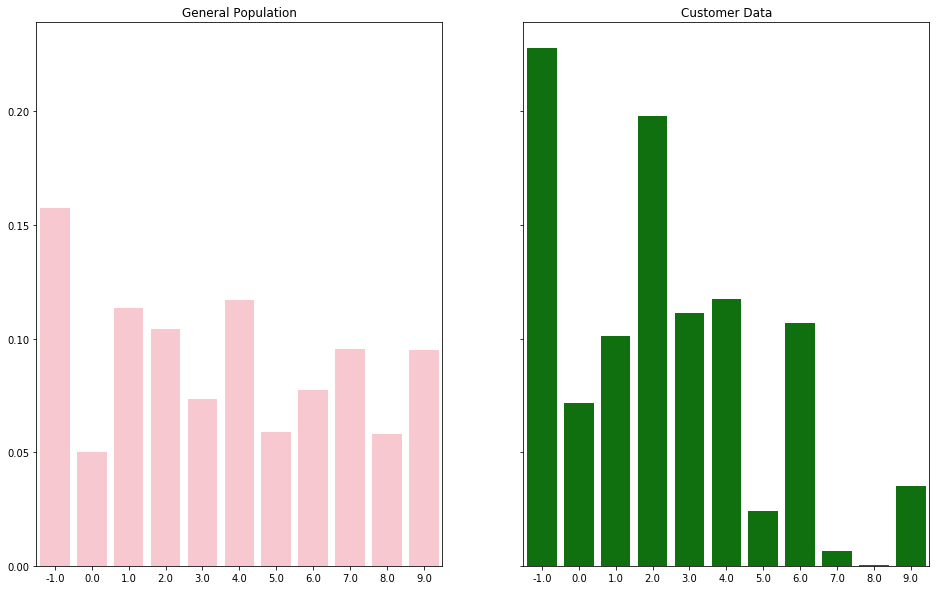

In [100]:
# Plot
fig, axes = plt.subplots(1,2, figsize=(16, 10), sharey=True)
sns.barplot(x=gen_clust_freq[:, 0], y=gen_clust_freq[:, 2], color='pink', ax=axes[0]);
sns.barplot(x=cust_clust_freq[:, 0], y=cust_clust_freq[:, 2], color='green', ax=axes[1]);

axes[0].set_title('General Population')
axes[1].set_title('Customer Data');

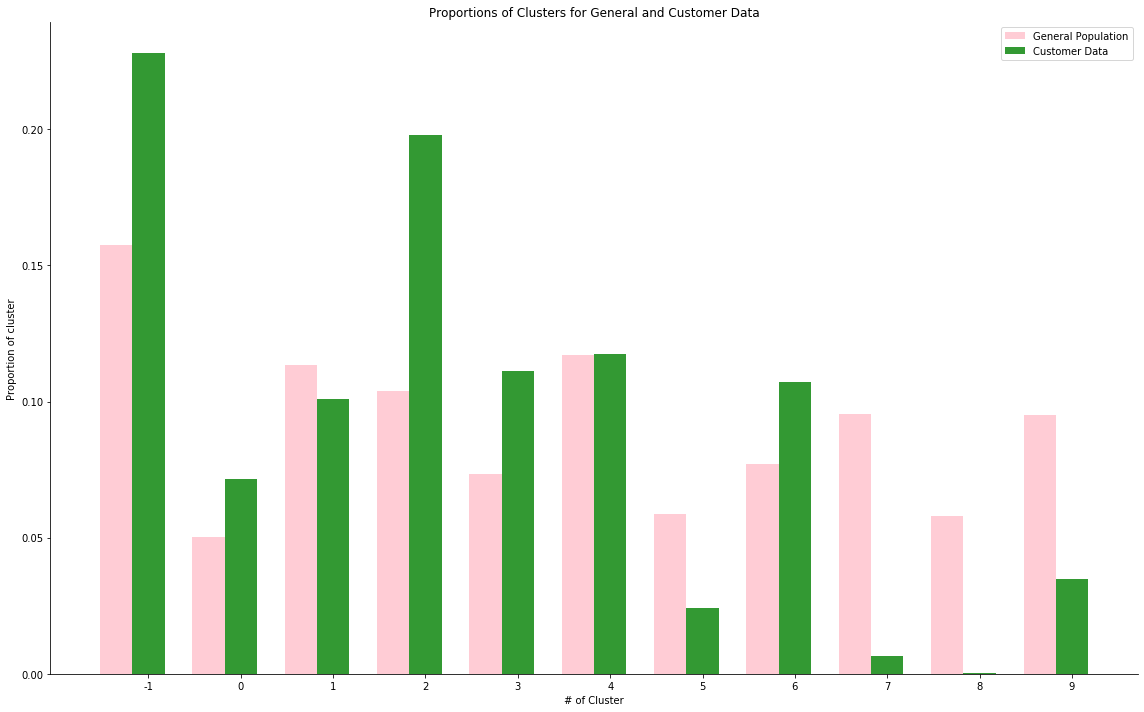

In [101]:
# create plot
fig, ax = plt.subplots(figsize=(16, 10))
index = np.append([-1], np.arange(10))
bar_width = 0.35
opacity = 0.8
 
gen = plt.bar(index, gen_clust_freq[:, 2], bar_width,
                 alpha=opacity,
                 color='pink',
                 label='General Population')
 
cust = plt.bar(index + bar_width, cust_clust_freq[:, 2], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Customer Data')
 
plt.xlabel('# of Cluster')
plt.ylabel('Proportion of cluster')
plt.title('Proportions of Clusters for General and Customer Data')
plt.xticks(index + bar_width, index)
plt.legend()
 
plt.tight_layout()
sns.set(style="whitegrid")
sns.despine();

In [102]:
df.shape

(747720, 432)

In [103]:
#this is similar to our last function but using kmeans
def map_weights_to_feats(pca, df, comp_no):
    '''Maps pca weights to features
    and returns two series with the highest
    positive weights/lowest negative
    weights'''

    weights = pd.DataFrame(np.round(pca.components_, 4), columns=df.keys())
    component = weights.iloc[comp_no - 1, :]
    comp_pos = component[component > 0].sort_values(ascending=False)
    comp_neg = component[component < 0].sort_values(ascending=True)

    return comp_pos, comp_neg

In [104]:
#apply map_weights_to_feats function to find first component
comp_pos1, comp_neg1 = map_weights_to_feats(pca, df_cust, 1)

In [105]:
comp_pos1, comp_neg1

(D19_GESAMT_ANZ_24                        0.1325
 SEMIO_VERT                               0.1301
 LP_FAMILIE_GROB                          0.1243
 D19_VERSAND_ANZ_24                       0.1223
 D19_GESAMT_ANZ_12                        0.1190
 FINANZ_MINIMALIST                        0.1178
 LP_FAMILIE_FEIN                          0.1122
 D19_SONSTIGE                             0.1100
 D19_VERSAND_ANZ_12                       0.1090
 ALTERSKATEGORIE_GROB                     0.1063
 LP_STATUS_GROB                           0.1045
 ONLINE_AFFINITAET                        0.1044
 FINANZ_VORSORGER                         0.1017
 MOVEMENT                                 0.1008
 GREEN_AVANTGARDE                         0.1008
 D19_GESAMT_ONLINE_QUOTE_12               0.1002
 D19_TECHNIK                              0.0989
 SEMIO_SOZ                                0.0985
 D19_BUCH_CD                              0.0982
 D19_VERSAND_ONLINE_QUOTE_12              0.0965
 D19_VOLLSORTIMENT  

In [106]:
comp_pos2, comp_neg2 = map_weights_to_feats(pca, df_cust, 2)
comp_pos2, comp_neg2

(KBA13_ANTG3                                  0.1598
 PLZ8_ANTG3                                   0.1576
 EWDICHTE                                     0.1518
 KBA13_ANTG4                                  0.1509
 PLZ8_ANTG4                                   0.1476
 KBA13_BAUMAX                                 0.1474
 ORTSGR_KLS9                                  0.1467
 KBA05_BAUMAX                                 0.1118
 FINANZ_HAUSBAUER                             0.1112
 PLZ8_ANTG2                                   0.1078
 WEALTH                                       0.1067
 KONSUMZELLE                                  0.1023
 KBA05_ANTG4                                  0.1002
 RELAT_AB                                     0.0986
 CAMEO_DEUG_2015                              0.0958
 HH_EINKOMMEN_SCORE                           0.0925
 STRUKTURTYP                                  0.0923
 KBA05_ANTG3                                  0.0915
 KBA13_ANTG2                                  

In [107]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
comp_pos3, comp_neg3 = map_weights_to_feats(pca, df_cust, 3)
comp_pos3, comp_neg3

(HH_EINKOMMEN_SCORE                                 0.1329
 KBA13_KW_0_60                                      0.1263
 KBA13_KMH_180                                      0.1260
 CAMEO_DEUG_2015                                    0.1158
 WEALTH                                             0.1147
 KKK                                                0.1108
 KBA13_SEG_KLEINWAGEN                               0.1080
 KBA13_KMH_140_210                                  0.1074
 KBA13_SEG_KLEINST                                  0.1038
 REGIOTYP                                           0.0987
 KBA13_CCM_1400                                     0.0935
 KBA05_KW1                                          0.0932
 KBA13_KRSHERST_FORD_OPEL                           0.0904
 KBA05_MAXHERST                                     0.0889
 KBA13_CCM_0_1400                                   0.0874
 KBA13_HERST_FORD_OPEL                              0.0873
 KBA13_BJ_2000                                      0.08

In [108]:
# Add cluster labels
df_cust_pca['cluster'] = X_cust_kmeans

In [109]:
def list_reconstruct_component(DF, model, nth_compo, pca):
    #reversing the reduction to get back to the original features
    listing = pd.DataFrame({'Features':list(DF.keys()),'Weights':pca.inverse_transform(model.cluster_centers_)[nth_compo]}).sort_values('Weights', axis=0, ascending=False).values.tolist()
    
    return listing

In [110]:
def plot_scaled_comparison(df_sample, kmeans, cluster):
    #plotting the clusters and their composition helper function
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
                                        pca.inverse_transform(kmeans.cluster_centers_[cluster]))),
                               orient='index').rename(columns={0: 'feature_values'}).sort_values('feature_values',
                                                                                                 ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');

In [111]:

def plot_cluster(df, model, cluster_list, title):
    #plotting the clusters and their composition
    size=len(cluster_list)
    plt.figure(figsize=(16, size*5))
    for i in range(size):
        plt.subplot(size,1,i+1)
        plot_scaled_comparison(df, model, cluster_list[i])
        plt.title(title + ' cluster ' + str(cluster_list[i]))
    plt.show()

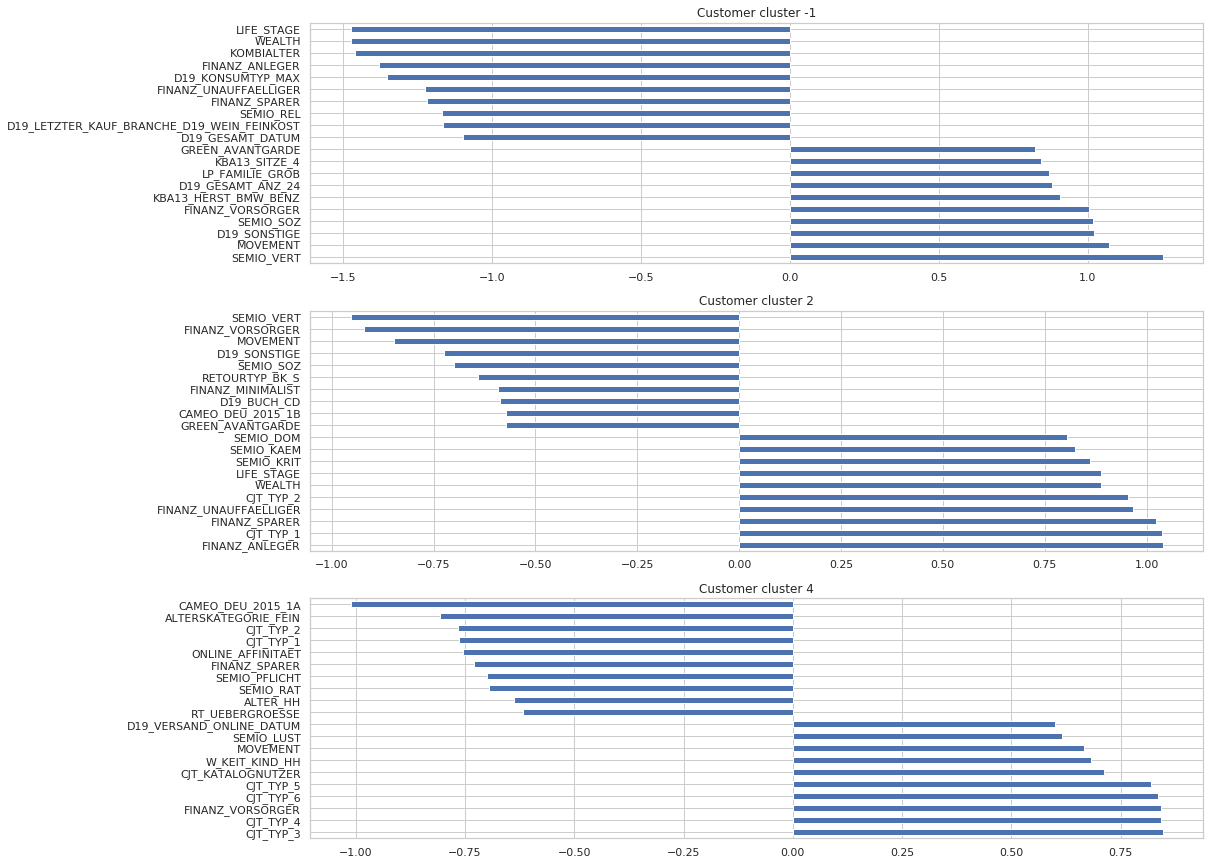

In [112]:
plot_cluster(df, model_10, [-1,2,4], 'Customer')

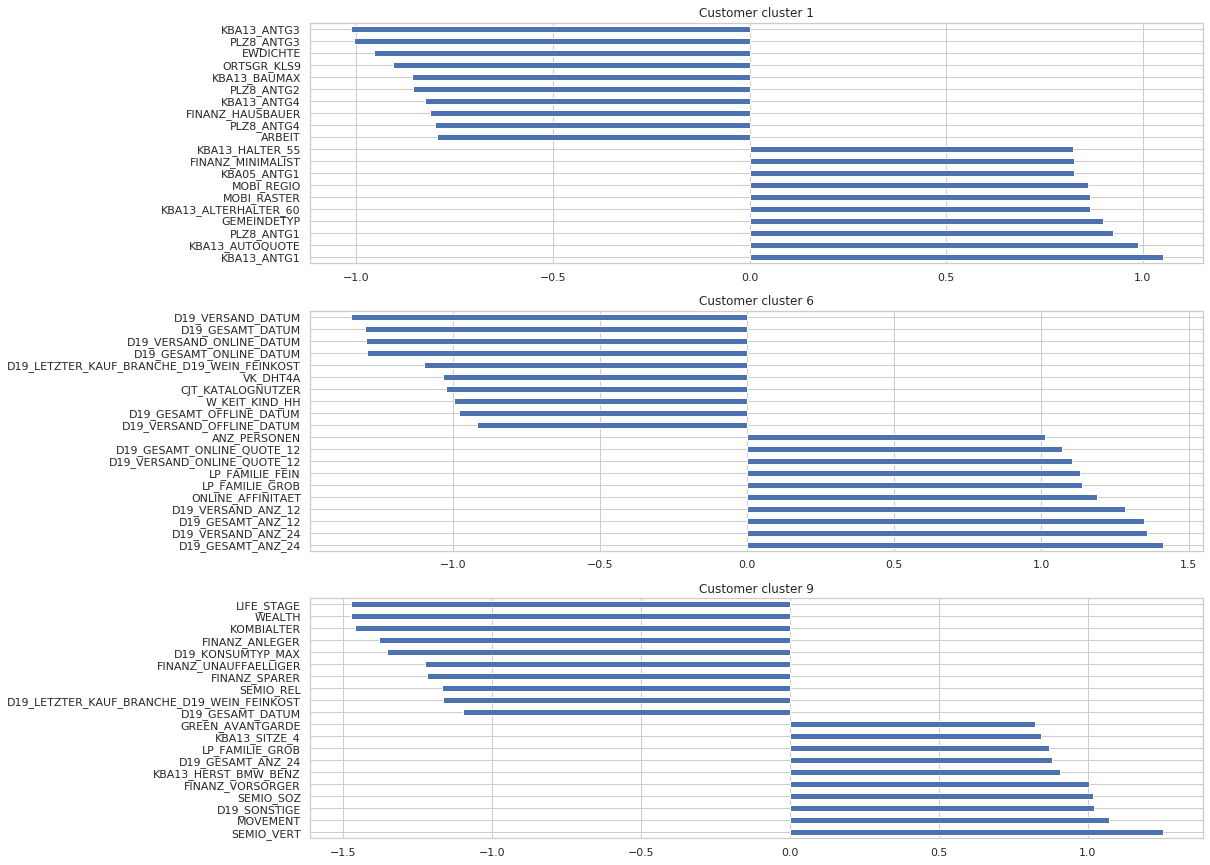

In [114]:
plot_cluster(df, model_10, [1,6,9], 'Customer')

These clusters, (3 being the gender cluster) show that the most overrepresented group is men that are less dreamful, less socially-minded, not financial minimalists. Since they have a higher financial status they also live in less densely populated areas. The negative weight for the age-generation principal component suggests these could be younger men,

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
# mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [123]:
#import models and scoring
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier,  AdaBoostClassifier, GradientBoostingClassifier
from IPython.display import clear_output


### Load data

In [124]:

body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='udacity-donotdelete-pr-cg1e1uk11mv7lb',Key='Udacity_MAILOUT_TRAIN.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_mailout_train = pd.read_csv(body, sep=';')
df_mailout_train.head()


/opt/conda/envs/Python-3.6-CUDA/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [125]:
df_mailout_train.drop(df_mailout_train.columns[df_mailout_train.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


In [126]:
df_mailout_train.shape

(42962, 367)

In [127]:
df_mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [128]:
mailout_train = df_mailout_train.copy()

In [129]:
mailout_train = clean_data(mailout_train)

[->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->] 100%


Convert missing value codes into NaN, OK
Remove selected columns, OK


[->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->] 100%
[->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->] 100%


Re-encode, fill and engineer column value, OK


In [130]:
mailout_train.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,2.0,1.0,8.0,8.0,15.0,0.000000,0.0,1.0,13.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,1.0,4.0,13.0,13.0,1.0,0.000000,0.0,2.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,1.0,1.0,9.0,7.0,0.0,0.049574,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,1.0,6.0,6.0,4.0,0.000000,0.0,2.0,4.0,0.0,...,0,0,0,0,0,1,0,0,0,0
4,2.0,1.0,9.0,9.0,53.0,0.000000,0.0,1.0,44.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
mailout_train.shape

(42962, 433)

In [132]:
# Split the data into features and target label
y = mailout_train['RESPONSE']
X = mailout_train.drop('RESPONSE', axis = 1)


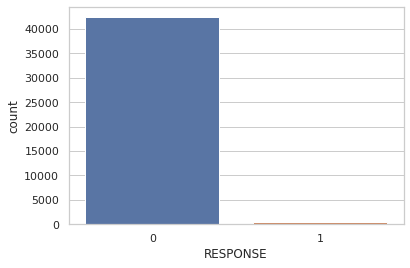

In [133]:
#plot the number of 0 and 1 responses
sns.countplot("RESPONSE",data=mailout_train)

# Find Best Model

In [134]:
# Import model packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=28)
skf.get_n_splits(X, y)
print(skf)

StratifiedKFold(n_splits=5, random_state=28, shuffle=False)


/opt/conda/envs/Python-3.6-CUDA/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [135]:
# TODO: Initialize the three models
clf_A = RandomForestClassifier()
clf_B = AdaBoostClassifier()
clf_C = GradientBoostingClassifier()

In [136]:
model_scores = {}
#This function prints out the model along with the roc_auc score with each fold
for i, clf in enumerate([clf_A, clf_B, clf_C]):

    # Create machine learning pipeline
    pipeline = Pipeline([
        ('scale', scaler),
        ('clf', clf)
    ])

    scores = []
    j = 0

    # Perform 5-fold validation
    for train_index, test_index in skf.split(X, y):
        j+=1
        print('Classifier {}: Fold {}...'.format(i+1, j))
        
        # Split the data into training and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train using the pipeline
        pipeline.fit(X_train, y_train)

        #Predict on the test data
        y_pred = pipeline.predict(X_test)

        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        print(score)

    model_scores[clf] = scores

Classifier 1: Fold 1...
0.5
Classifier 1: Fold 2...
0.4999410794249352
Classifier 1: Fold 3...
0.5
Classifier 1: Fold 4...
0.5
Classifier 1: Fold 5...
0.5
Classifier 2: Fold 1...
0.4999410794249352
Classifier 2: Fold 2...
0.5046728971962616
Classifier 2: Fold 3...
0.5
Classifier 2: Fold 4...
0.4999410794249352
Classifier 2: Fold 5...
0.5
Classifier 3: Fold 1...
0.4999410794249352
Classifier 3: Fold 2...
0.4997643176997407
Classifier 3: Fold 3...
0.5045991399819458
Classifier 3: Fold 4...
0.49970539712467593
Classifier 3: Fold 5...
0.5045991399819458


In [137]:
#map out df of model performances
df_scores= pd.DataFrame(model_scores)
df_scores.columns = ['RandomForestClassifier',  'AdaBoostClassifier', 'GradientBoostingClassifier']
df_scores

,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
0,0.500000,0.499941,0.499941
1,0.499941,0.504673,0.499764
2,0.500000,0.500000,0.504599
3,0.500000,0.499941,0.499705
4,0.500000,0.500000,0.504599


## Improve Model

Since RandomForestClassifier had the highest scores, we can tune it to increase the performance.

In [138]:
#Display parameters to see which ones to tune
clf_A.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [139]:

#define parameters to cycle through
params = {
          "max_depth"         : [3,4],
          "n_estimators"      : [100,1000],
          "min_samples_split" : [2,4]}

# start the search
grid = GridSearchCV(clf_A, params, scoring='roc_auc', cv=5)
grid_fit = grid.fit(X, y)

In [140]:

#get the wining configuration 
best = grid_fit.best_estimator_
best.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

Thus, the best parameters are:
                        bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)>

In [141]:
#refit the model
best = best.fit(X, y)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [142]:

body = client_a858d8f03f374020bfd0da2bb1a90a17.get_object(Bucket='udacity-donotdelete-pr-cg1e1uk11mv7lb',Key='Udacity_MAILOUT_TEST.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_mailout_test = pd.read_csv(body, sep=';')
df_mailout_test.head()


/opt/conda/envs/Python-3.6-CUDA/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [143]:
df_mailout_test.drop(df_mailout_test.columns[df_mailout_test.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


In [144]:
df_mailout_test.shape

(42833, 366)

In [145]:
mailout_test = df_mailout_test.copy()

In [146]:
mailout_test_clean = clean_data(mailout_test)

[->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->] 100%


Convert missing value codes into NaN, OK
Remove selected columns, OK


[->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->] 100%
[->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->] 100%


Re-encode, fill and engineer column value, OK


In [147]:
# Check for missing column in mailout_test
missing = list(np.setdiff1d(df_cust.columns, mailout_train.columns))
missing

['CUSTOMER_GROUP',
 'ONLINE_PURCHASE',
 'PRODUCT_GROUP_COSMETIC',
 'PRODUCT_GROUP_COSMETIC_AND_FOOD',
 'PRODUCT_GROUP_FOOD',
 'row_nan_perc',
 'row_nans']

In [148]:
#function that drop different input columns
def drop_diff_colls(df_predict):
    #some features are different in the new df and the model cant handle this -> drop them
    df_predict = df_predict.drop(missing, 1)
    return df_predict

In [149]:
df_test = drop_diff_colls(df_cust)

In [150]:
mailout_test_clean.shape

(42833, 432)

In [151]:
df_mailout_test.shape

(42833, 366)

In [152]:
X = np.array(mailout_test_clean)

In [153]:

#Predict on the test data
predictions = best.predict_proba(X)[:,1]

In [154]:
submission = pd.DataFrame(index=df_mailout_test['LNR'].astype('int32'), data=predictions)

In [155]:

submission.rename(columns={0: "RESPONSE"}, inplace=True)
submission.head()


,RESPONSE
LNR,
1754,0.016974
1770,0.015449
1465,0.012378
1470,0.010409
1478,0.013068


In [167]:
project.save_data(file_name = "kaggle_competition_2.csv",data = submission.to_csv())

{'file_name': 'kaggle_competition.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'udacity-donotdelete-pr-cg1e1uk11mv7lb',
 'asset_id': '4afca08f-25cf-46be-b953-27c15d01250f'}

In [157]:
#save the prediction
# submission.to_csv('kaggle_competition.csv', sep=',', index = False)